In [66]:
import pandas as pd
from os import listdir
import numpy as np
import random
import scipy.optimize as opt
import warnings
from Vasicek_one_factor import simulate_Vasicek_One_Factor
warnings.filterwarnings("ignore")

# Data

In [67]:
mypath = "Final"
data_list = listdir(mypath)

In [68]:
data = pd.DataFrame()
for col in data_list:
    tmp = pd.read_csv('Final/'+col, index_col = 'Date')
    data = pd.concat([data,tmp])
data.index = pd.DatetimeIndex(data.index)
df = pd.DataFrame(data.sort_index()['3 Mo'].copy())

In [69]:
df['3 Mo_shift'] = df['3 Mo'].shift(1) 
df['diff'] = df['3 Mo'] - df['3 Mo_shift']

In [70]:
db = df.dropna().copy()

# 估參數：k, theta , sigma

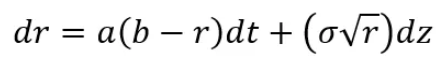

In [71]:
global N
N = 252
dt = 1/N

def fun_MLE(x): 
    
    random.seed(108)
    np.random.seed(108)
    # scipy
    DF = db_tmp.to_numpy()
    
    r0 = DF[:,0]
    r1 = DF[:,1]
    dr = DF[:,2]

    mu, sigma = 0, dt # mean and standard deviation
    s = np.random.normal(mu, sigma, len(DF))
    a = x[0]
    b = x[1]
    sigma = x[2]
    # fit_dr =  a*(b-r0)*dt + sigma*np.sqrt(r0)*s
    fit_dr =  a*(b-r0)*dt + sigma*np.sqrt(r0)*s
    error = np.sum(np.abs(fit_dr-dr))
    target = -np.log(error)
    # target = -error
    return target

In [72]:
initial = (0.3,0.3,0.3)
tmp = 0.1
constraints = ( 
                # {'type':'ineq','fun':lambda x : 2*x[0]*x[1]-x[2]**2},
                {'type':'ineq','fun':lambda x : x[2]},
                {'type':'ineq','fun':lambda x : -x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[2]+1*tmp},
                {'type':'ineq','fun':lambda x : x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : x[2]+1*tmp},
                )
# parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
# bp = parameters['x']

# CIR

In [73]:
from CIR import CIR
import matplotlib.pyplot as plt

def estimate(bp,r0, period = 2):
    # assume mean-reverted speed = 1, mean-reverted level = 0.05, vol of interest rate = 0.05, initial interest rate = 0.05, and pass to an object named C
    V = simulate_Vasicek_One_Factor(r0, bp[0], bp[1], bp[2], dt*period, dt) 

    return V.iloc[-1].values[0]



In [74]:
ROLLING = 30 #調整參數週期
dates = db[::ROLLING].index
period = 2 # 預測下一期
global db_tmp


In [75]:
bps = []
for i in range(1,len(dates)):
    db_tmp = db[((db.index < dates[i]) & (db.index >= dates[i-1]))]
    parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
    bp = parameters['x']
    bps.append(bp)

In [76]:
df_pa = pd.DataFrame(bps, columns = ['a','b','sigma'],index = dates[1:])
df_pa_me =  pd.merge(df, df_pa, left_on = 'Date', right_on = 'Date',how = 'outer').ffill()
DB = df_pa_me.dropna()

In [77]:
estimates_1 = []
# estimates_2 = []
for i in range(0,len(DB)):
    estimate_1= estimate((DB['a'][i],DB['b'][i], DB['sigma'][i]),DB['3 Mo_shift'][i], period = period)
    estimates_1.append(estimate_1)
    # estimates_2.append(estimate_2)
DB['pred_1'] = estimates_1 
# DB['pred_2'] = estimates_2

In [78]:
estimate((DB['a'][i],DB['b'][i], DB['sigma'][i]),DB['3 Mo_shift'][i], period = period)

5.460211304429698

In [79]:
DB

,3 Mo,3 Mo_shift,diff,a,b,sigma,pred_1
Date,,,,,,,
2010-02-18,0.10,0.10,0.00,0.1,0.1,0.1,0.108127
2010-02-19,0.11,0.10,0.01,0.1,0.1,0.1,0.110069
2010-02-22,0.11,0.11,0.00,0.1,0.1,0.1,0.101145
2010-02-23,0.12,0.11,0.01,0.1,0.1,0.1,0.110317
2010-02-24,0.12,0.12,0.00,0.1,0.1,0.1,0.114156
...,...,...,...,...,...,...,...
2023-05-31,5.52,5.55,-0.03,0.1,0.1,0.1,5.542502
2023-06-01,5.50,5.52,-0.02,0.1,0.1,0.1,5.525097
2023-06-02,5.50,5.50,0.00,0.1,0.1,0.1,5.498097


Text(0.5, 1.0, 'No Rolling Vasicek')

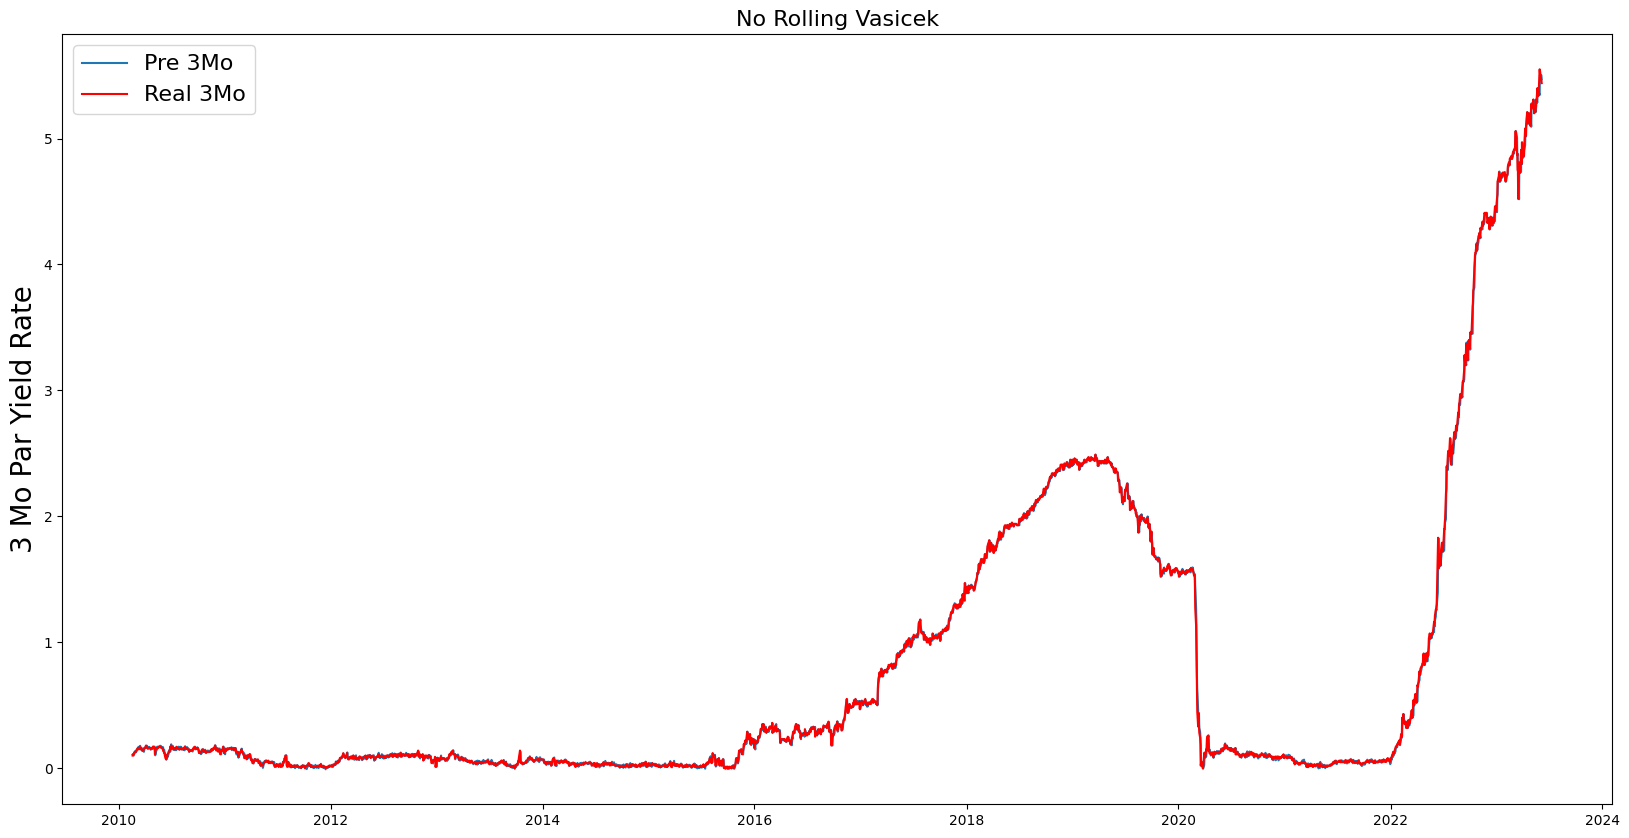

In [80]:
plt.figure(figsize=(20,10))
l1,= plt.plot(DB['pred_1'])
# l2,= plt.plot(DB['pred_2'],'b-',markersize=4)
l3, = plt.plot(DB['3 Mo'],'r-',markersize=4)
plt.ylabel('3 Mo Par Yield Rate',fontsize = 20)
plt.legend(handles=[l1, l3], labels=['Pre 3Mo', 'Real 3Mo'], fontsize = 16)
plt.title('No Rolling Vasicek', fontsize = 16)

Text(0.5, 1.0, 'Rolling Vasicek')

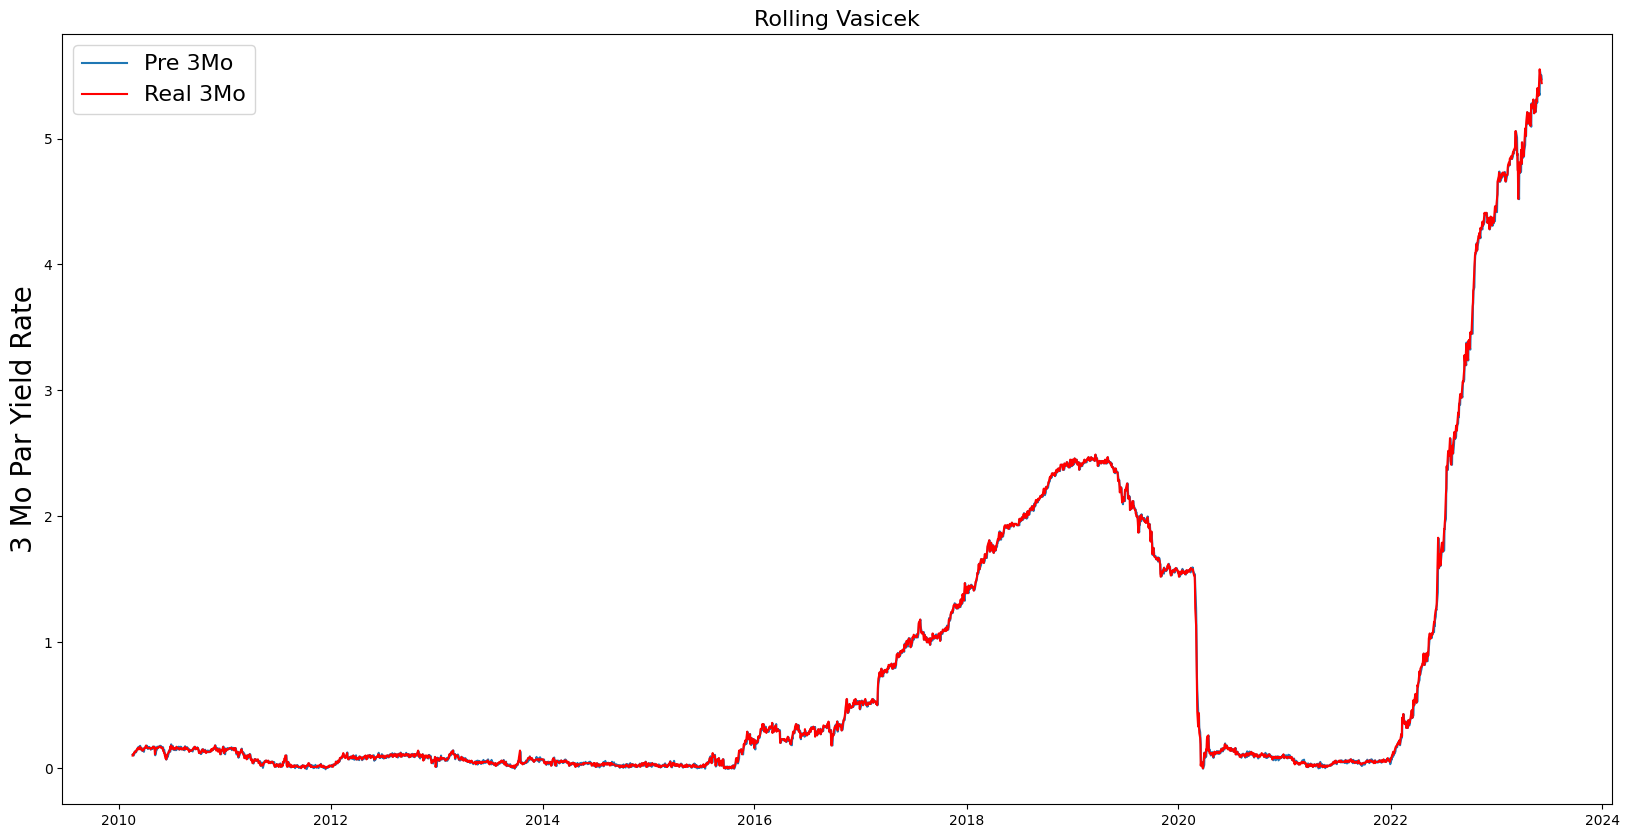

In [83]:
plt.figure(figsize=(20,10))
l1,= plt.plot(DB['pred_1'])
# l2,= plt.plot(DB['pred_2'],'b-',markersize=4)
l3, = plt.plot(DB['3 Mo'],'r-',markersize=4)
plt.ylabel('3 Mo Par Yield Rate',fontsize = 20)
plt.legend(handles=[l1, l3], labels=['Pre 3Mo', 'Real 3Mo'], fontsize = 16)
plt.title('Rolling Vasicek', fontsize = 16)


# Error Calculated : RMSE MSE SSE

In [ ]:
DB

,3 Mo,3 Mo_shift,diff,a,b,sigma,pred_1,pred_2
Date,,,,,,,,
2010-02-18,0.10,0.10,0.00,1.0,1.0,1.0,0.112361,0.110763
2010-02-19,0.11,0.10,0.01,1.0,1.0,1.0,0.112361,0.110763
2010-02-22,0.11,0.11,0.00,1.0,1.0,1.0,0.122750,0.121152
2010-02-23,0.12,0.11,0.01,1.0,1.0,1.0,0.122750,0.121152
2010-02-24,0.12,0.12,0.00,1.0,1.0,1.0,0.133120,0.131523
...,...,...,...,...,...,...,...,...
2023-05-31,5.52,5.55,-0.03,1.0,0.5,1.0,5.595440,5.593842
2023-06-01,5.50,5.52,-0.02,1.0,0.5,1.0,5.565382,5.563784
2023-06-02,5.50,5.50,0.00,1.0,0.5,1.0,5.545343,5.543745


In [84]:
# MSE
MSE = np.sum((DB['pred_1'] - DB['3 Mo'])**2)/len(DB)

# RMSE
RMSE = np.sqrt(MSE)

# MAPE
MAPE = np.sum(np.abs((DB['pred_1']-DB['3 Mo'])/DB['3 Mo']))/len(DB)

In [85]:
MSE

0.00072068113717557

In [ ]:
np.sum(np.abs((DB['pred_1']-DB['3 Mo'])/DB['3 Mo']))

inf

In [ ]:
tmp = np.abs((DB['pred_1']-DB['3 Mo'])/DB['3 Mo'])

In [ ]:
MSE

0.0009068566721827948

In [ ]:
MAPE

inf

# Vacisek